Heat transfer of railway brake disc

Author: yanjun zhang


## 1: Start

In [1]:
import matplotlib.pyplot as plt
import pyvista
import ufl
import numpy as np
import dolfinx

from petsc4py import PETSc
from mpi4py import MPI

from dolfinx import fem, mesh, io, plot
from dolfinx.fem.petsc import assemble_vector, assemble_matrix, create_vector, apply_lifting, set_bc

# Define temporal parameters
t = 0  # Start time
T = 5  # Final time
num_steps = 30
dt = T / num_steps  # time step size


/home/yanjun/.local/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


## 2: Mesh

run mesh_brake disc.py to get disc.mesh

In [2]:
from dolfinx.io import gmshio
from mpi4py import MPI
import pyvista
from dolfinx import plot


filename = "3-10" # mesh
# New mesh, 10 is min mesh size, 30 is the maximum mesh size
#import sys
#sys.path.append('/home/yanjun/Documents/FEniCSx/Tutorial/Mesh/')
#from mesh_disc import mesh_brake_disc
#mesh_brake_disc(3,10,filename)

domain, cell_markers, facet_markers = gmshio.read_from_msh(filename+".msh", MPI.COMM_WORLD, 0, gdim=3)
gdim, tdim = 3, 2


Info    : Reading '3-10.msh'...
Info    : 168 entities
Info    : 10751 nodes
Info    : 43604 elements
Info    : Done reading '3-10.msh'


#below gdim change to tdim is plot in 2D
pyvista.start_xvfb()


topology, cell_types, geometry = plot.vtk_mesh(domain, gdim)

grid = pyvista.UnstructuredGrid(topology, cell_types, geometry)
plotter = pyvista.Plotter()
plotter.add_mesh(grid, show_edges=True)
plotter.view_xy()

plotter.show()


## 3: Initial condition

Note that we have used a much higher resolution that before to better resolve features of the solution.
We also easily update the intial and boundary conditions. Instead of using a class to define the initial condition, we simply use a function

In [3]:
# Create initial condition
from find_com_e import find_common_e

V = fem.FunctionSpace(domain, ("Lagrange", 1))

# apply to all the x
def initial_condition(x):
     return (25 + x[0]-x[0])
    
u_n = fem.Function(V)
u_n.name = "u_n"
u_n.interpolate(initial_condition)

# Create boundary condition
fdim = domain.topology.dim - 1
#lambda x, y, z: (x - center_x)**2 + (y - center_y)**2 <= radius**2 and np.isclose(z, target_z)

import sys
## when change a new computer, below path is inconvenient, need to find a bettwe way to use this function.
sys.path.append('/home/yanjun/Documents/FEniCSx/Tutorial/Mesh/')
from rub_co import get_rub_coordinate
x_co, y_co = get_rub_coordinate()

bc_list = []
for i, (x_c, y_c) in enumerate(zip(x_co, y_co), start=1):
    var_name = f"bc_facets{i}"
    
    tag= mesh.locate_entities_boundary(
       domain, fdim, lambda x: (x[0]-x_c)**2 + (x[1]-y_c)**2  <= 324 )
        
    globals()[var_name] = tag
    bc_list.append(globals()[var_name])
    # rubbing elements

bc_disc = mesh.locate_entities_boundary(
    domain, fdim , lambda x:  np.isclose(x[2], 20) )

bc_all = find_common_e(bc_disc, bc_list)


## PETSC.Scalarype(X), this X is the value of boundary condition, like inlet temperature is 20, then here X is 20.
# Scalartype means constant value.
bc = fem.dirichletbc(PETSc.ScalarType(100), fem.locate_dofs_topological(V, fdim, bc_all), V)

print('1:fdim is','\n', fdim)
#print('2: boundary_facets is', '\n', bc_all)
#print('bc_all is','\n', bc_all)
print(bc_facets15)

1:fdim is 
 2
[42583 42584 42586 42591 42596 42597 42600 42605 42829 42945 43115 43117
 43121 43146 43148 43153 43334 43338 43341 43345 43567 43597 43858 43859
 43860 43885 43886 43887 75117 75124 75134 75136 75164 75173 75442 75753
 75815 75824 75853 75869 76126 76248 76476 76894 76896 76971 76972 77039
 77695 77839 77840 78171 78403 78406 78531 78532]


## 4: Time-dependent output
To visualize the solution in an external program such as Paraview, we create a an `XDMFFile` which we can store multiple solutions in. The main advantage with an XDMFFile, is that we only need to store the mesh once, and can append multiple solutions to the same grid, reducing the storage space.
The first argument to the XDMFFile is which communicator should be used to store the data. As we would like one output, independent of the number of processors, we use the `COMM_WORLD`. The second argument is the file name of the output file, while the third argument is the state of the file,
this could be read (`"r"`), write (`"w"`) or append (`"a"`).

In [4]:
xdmf = io.XDMFFile(domain.comm, "temperature.xdmf", "w")
xdmf.write_mesh(domain)

# Define solution variable, and interpolate initial solution for visualization in Paraview
uh = fem.Function(V)
uh.name = "uh"
uh.interpolate(initial_condition)
xdmf.write_function(uh, t)

## 5: Variational problem and solver


In [5]:
u, v = ufl.TrialFunction(V), ufl.TestFunction(V)
f = fem.Constant(domain, PETSc.ScalarType(0))
a = u * v * ufl.dx + dt * ufl.dot(ufl.grad(u), ufl.grad(v)) * ufl.dx
L = (u_n + dt * f) * v * ufl.dx

## 6: Preparing linear algebra structures for time dependent problems
We note that even if `u_n` is time dependent, we will reuse the same function for `f` and `u_n` at every time step. We therefore call `dolfinx.fem.form` to generate assembly kernels for the matrix and vector.

In [6]:
# assembly matrix and vector

bilinear_form = fem.form(a)
linear_form = fem.form(L)

We observe that the left hand side of the system, the matrix $A$ does not change from one time step to another, thus we only need to assemble it once. However, the right hand side, which is dependent on the previous time step `u_n`, we have to assemble it every time step. Therefore, we only create a vector `b` based on `L`, which we will reuse at every time step.

In [7]:
A = assemble_matrix(bilinear_form, bcs=[bc])
A.assemble()
b = create_vector(linear_form)

In [8]:
#print(b.view())
#print(A.view())

## 7: Using petsc4py to create a linear solver
As we have already assembled `a` into the matrix `A`, we can no longer use the `dolfinx.fem.petsc.LinearProblem` class to solve the problem. Therefore, we create a linear algebra solver using PETSc, and assign the matrix `A` to the solver, and choose the solution strategy.

In [9]:
solver = PETSc.KSP().create(domain.comm)
solver.setOperators(A)
solver.setType(PETSc.KSP.Type.PREONLY)
solver.getPC().setType(PETSc.PC.Type.LU)

## 8:Visualization of time dependent problem using pyvista
We use the DOLFINx plotting functionality, which is based on pyvista to plot the solution at every $15$th time step. We would also like to visualize a colorbar reflecting the minimal and maximum value of $u$ at each time step. We use the following convenience function `plot_function` for this:

In [10]:
import matplotlib as mpl
pyvista.start_xvfb()

grid = pyvista.UnstructuredGrid(*plot.vtk_mesh(V))

plotter = pyvista.Plotter()
plotter.open_gif("u_time.gif", fps=30)

grid.point_data["uh"] = uh.x.array
warped = grid.warp_by_scalar("uh", factor=1)

viridis = mpl.colormaps.get_cmap("viridis").resampled(25)
sargs = dict(title_font_size=25, label_font_size=20, fmt="%.2e", color="black",
             position_x=0.1, position_y=0.8, width=0.8, height=0.1)

renderer = plotter.add_mesh(warped, show_edges=True, lighting=False,
                            cmap=viridis, scalar_bar_args=sargs,
                            clim=[0, max(uh.x.array)])

## 9:Updating the solution and right hand side per time step
To be able to solve the variation problem at each time step, we have to assemble the right hand side and apply the boundary condition before calling
`solver.solve(b, uh.vector)`. We start by resetting the values in `b` as we are reusing the vector at every time step.
The next step is to assemble the vector, calling `dolfinx.fem.petsc.assemble_vector(b, L)` which means that we are assemble the linear for `L(v)` into the vector `b`. Note that we do not supply the boundary conditions for assembly, as opposed to the left hand side.
This is because we want to use lifting to apply the boundary condition, which preserves symmetry of the matrix $A$ if the bilinear form $a(u,v)=a(v,u)$ without Dirichlet boundary conditions.
When we have applied the boundary condition, we can solve the linear system and update values that are potentially shared between processors.
Finally, before moving to the next time step, we update the solution at the previous time step to the solution at this time step.

for i in range(num_steps):
    t += dt

    # Update the right hand side reusing the initial vector
    with b.localForm() as loc_b:
        loc_b.set(0)
    assemble_vector(b, linear_form)

    # Apply Dirichlet boundary condition to the vector
    apply_lifting(b, [bilinear_form], [[bc]])
    b.ghostUpdate(addv=PETSc.InsertMode.ADD_VALUES, mode=PETSc.ScatterMode.REVERSE)
    set_bc(b, [bc])

    # Solve linear problem
    solver.solve(b, uh.vector)
    uh.x.scatter_forward()

    # Update solution at previous time step (u_n)
    u_n.x.array[:] = uh.x.array

    # Write solution to file
    xdmf.write_function(uh, t)
    # Update plot
    warped = grid.warp_by_scalar("uh", factor=0.1)
    plotter.update_coordinates(warped.points.copy(), render=False)
    plotter.update_scalars(uh.x.array, render=False)
    plotter.write_frame()
plotter.close()
xdmf.close()

In [11]:
from rotation_co import rub_rotation
import numpy as np

degree = 20
total_degree = 0

for i in range(num_steps):
    t += dt
    # update the location
    x_co, y_co = rub_rotation (x_co, y_co, degree)
    bc_list = []    
    for i, (x_c, y_c) in enumerate(zip(x_co, y_co), start=1):
       var_name = f"bc_facets{i}"
       tag= mesh.locate_entities_boundary(
       domain, fdim, lambda x: (x[0]-x_c)**2 + (x[1]-y_c)**2  <= 324 )
       globals()[var_name] = tag
       bc_list.append(globals()[var_name])
    bc_disc = mesh.locate_entities_boundary(
        domain, fdim , lambda x:  np.isclose(x[2], 20) )
    bc_all = find_common_e(bc_disc, bc_list)
    bc = fem.dirichletbc(PETSc.ScalarType(100), fem.locate_dofs_topological(V, fdim, bc_all), V)
    
    total_degree += degree  # Incrementing degree by 10 in each step
    sys.stdout.write('\rRotation has applied for {} degree'.format(total_degree))
    sys.stdout.flush()

    

    ## Matrix assemble
    A = assemble_matrix(bilinear_form, bcs=[bc])
    A.assemble()

    solver = PETSc.KSP().create(domain.comm)
    solver.setOperators(A)
    solver.setType(PETSc.KSP.Type.PREONLY)
    solver.getPC().setType(PETSc.PC.Type.LU)

    ## Mesh
    
      
    
    # Update the right hand side reusing the initial vector
    with b.localForm() as loc_b:
        loc_b.set(0)
    assemble_vector(b, linear_form)

    # Apply Dirichlet boundary condition to the vector
    apply_lifting(b, [bilinear_form], [[bc]])
    b.ghostUpdate(addv=PETSc.InsertMode.ADD_VALUES, mode=PETSc.ScatterMode.REVERSE)
    set_bc(b, [bc])

    # Solve linear problem
    solver.solve(b, uh.vector)
    uh.x.scatter_forward()

    # Update solution at previous time step (u_n)
    u_n.x.array[:] = uh.x.array

    # Write solution to file
    xdmf.write_function(uh, t)
    # Update plot
    warped = grid.warp_by_scalar("uh", factor=0.5)
    plotter.update_coordinates(warped.points.copy(), render=False)
    plotter.update_scalars(uh.x.array, render=False)
    plotter.write_frame()
    
plotter.close()
xdmf.close()
print()

Rotation has applied for 20 degree

  warnings.warn(

  warnings.warn(



Rotation has applied for 600 degree


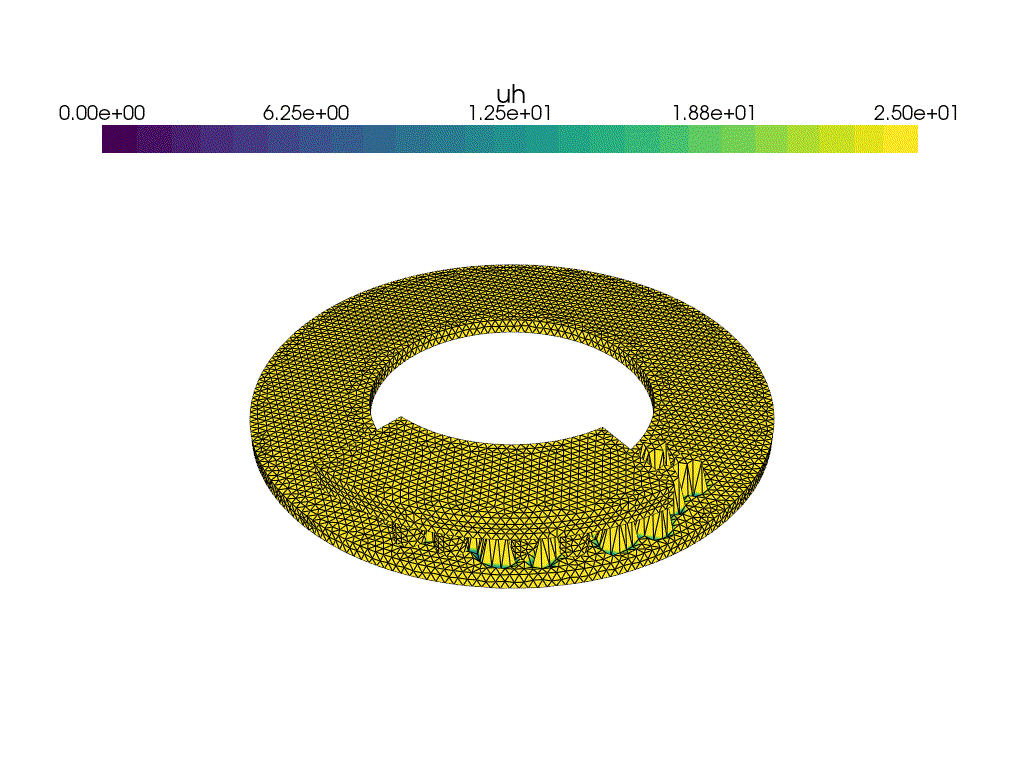

In [12]:
# Display the GIF
from IPython.display import display, Image

display(Image(filename = 'u_time.gif'))

# Original solver

for i in range(num_steps/2):
    t += dt

    # Update the right hand side reusing the initial vector
    with b.localForm() as loc_b:
        loc_b.set(0)
    assemble_vector(b, linear_form)

    # Apply Dirichlet boundary condition to the vector
    apply_lifting(b, [bilinear_form], [[bc]])
    b.ghostUpdate(addv=PETSc.InsertMode.ADD_VALUES, mode=PETSc.ScatterMode.REVERSE)
    set_bc(b, [bc])

    # Solve linear problem
    solver.solve(b, uh.vector)
    uh.x.scatter_forward()

    # Update solution at previous time step (u_n)
    u_n.x.array[:] = uh.x.array

    # Write solution to file
    xdmf.write_function(uh, t)
    # Update plot
    warped = grid.warp_by_scalar("uh", factor=0.5)
    plotter.update_coordinates(warped.points.copy(), render=False)
    plotter.update_scalars(uh.x.array, render=False)
    plotter.write_frame()
plotter.close()
xdmf.close()